When we made our [General Election 2024 website](https://ge2024.hexmap.uk/), we processed demographic data for each constituency. One of the topics in that data was housing tenure. For each constituency there is a percentage of homes owned outright, with a mortgage or loan, private rented, social rent, and other. Here we are going to explore the data from the results of the election and the housing tenure breakdown for each constituency.

First, lets import some modules to help us and set up paths so that they're system independent.

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["Arial"]
ROOT = Path('../')
ROOT.resolve()

PosixPath('/Users/lukestrange/Code/housing')

For election results, we'll use the Commons Library [detailed results by constituency CSV](https://researchbriefings.files.parliament.uk/documents/CBP-10009/HoC-GE2024-results-by-constituency.csv). We'll download this at put it in the `data/misc` folder. It's in pretty good shape. We don't need all the columns so we will specify which ones we do need when reading the CSV. `ONS ID` is the code for the constituency. `First party` is the winning party. The rest should be self-explanatory.

In [2]:
ge_results = pd.read_csv(ROOT / 'data/misc/HoC-GE2024-results-by-constituency.csv', 
                         usecols=['ONS ID', 'First party', 'Electorate', 'Valid votes', 'Invalid votes'])

In [3]:
geo_codes = pd.read_csv(ROOT / 'metadata/lookups/Westminster_Parliamentary_Constituencies_(Future)_Names_and_Codes_in_the_United_Kingdom_v2.csv',
                        usecols=['PCON24CD', 'PCON24NM'])

Breakdown of housing tenure by new (May 2024) parliamentary constituencies is a bit more involved. Commons library has new [constituency data dashboards](https://commonslibrary.parliament.uk/type/data-dashboard/), but the one on housing tenure hasn't yet been updated. So, we'll use the XLSX file on the [data for new constituencies](https://commonslibrary.parliament.uk/constituency-boundary-review-data-for-new-constituencies/) page. Breakdown on housing tenure is only available for England, Wales and Northern Ireland. The XLSX file is 1.2MB, which is very large. I'll put it in the raw directory and not check it into GitHub. If you wanted to run this code, you'd need a copy of the XLSX file.

We need some code to help clean the data and put it all together. I'm going to write these as functions to save time, as there are multiple sheets in the xlsx file to read.

`get_variable` is a utility function that filters the data set by selecting the variable `topic_name` from the column `col_name`.

`get_data` is collection of steps to clean and reshape the data in the XLSX file. Given that we'll need to do this across 2 different sheet, and there are other potential variables we may want to investigate in the future, it's worth generalising this code somewhat.

`get_data` takes 3 arguments: `sheet_name`: the sheet in the XLSX file to read, `topic_name`: passed through to `get_variable`, and `drop_cols`: columns we won't need at the end.

In [4]:
def get_variable(data, col_name, topic_name):
    data = data.loc[data[col_name] == topic_name]
    return data

def get_data(sheet_name, topic_name, drop_cols, value_type=float, header=2, is_percent=True):
    # Set file path
    path = 'raw/Demographic-data-for-new-parliamentary-constituencies-May-2024.xlsx'

    # Read the file and cut the data by topic_name
    data = data = pd.read_excel(ROOT / path, sheet_name=sheet_name, header=header).pipe(get_variable, 'Topic', topic_name)

    # Fix a naming error
    data.replace('Ynys Mon', 'Ynys Môn', inplace=True)

    # Drop unused columns
    data.drop(columns=drop_cols, inplace=True)
    
    # Rename columns to merge with constituency codes
    data.rename(columns={'New constituency name': 'PCON24NM', 'Constituency value': topic_name}, inplace=True)

    # Convert the data types to integer
    data[topic_name] = data[topic_name].astype(value_type)

    # Get a list of unique Variable names, and how many there are, for the given topic.
    v_names = list(data['Variable'].unique())
    v_num = len(v_names)

    # If there are multiple variables for a given topic, we want to pivot the data so that each of of these has its own column.
    if v_num > 1:
            print(f'More than one variable type: {v_names}. Pivoting the data\n')
            data = data.pivot(index='PCON24NM', columns='Variable', values=topic_name)
    
    # If there is only one variable, we can drop the variable column as we don't need it.
    if v_num == 1:
        print(f'Only one variable type: {v_names}. Dropping the variable column\n')
        data.drop(columns='Variable', inplace=True)

    # Now we can merge the geography codes and data, and set the index to the geography code.
    data = data.merge(geo_codes, on='PCON24NM', how='inner').set_index('PCON24CD', drop=True)

    # If the data is a pct, make it out of 100 and round to 1dp.
    if is_percent:
        data[v_names] = data[v_names].mul(100).round(1)

    # Drop PCON24NM column as we don't need it.
    data.drop(columns='PCON24NM', inplace=True)

    return data

In [5]:
ew_housing_tenure = get_data('EW_data', 'Housing tenure', ['Topic', 'England & Wales value'])
ni_housing_tenure = get_data('NI_data', 'Housing tenure', ['Topic', 'Northern Ireland value'])

# Concatenate (join) the two dataframes.
uk_tenure = pd.concat([ew_housing_tenure, ni_housing_tenure])

# While we're here write this file to the data directory
uk_tenure.to_csv(ROOT / 'data/tenure/tenure_type.csv')
uk_tenure

More than one variable type: ['Other tenure', 'Owned outright', 'Owned with a mortgage or loan', 'Private rented', 'Social rented']. Pivoting the data

More than one variable type: ['Owned outright', 'Owned with a mortgage or loan', 'Private rented', 'Social rented', 'Other tenure']. Pivoting the data



,Other tenure,Owned outright,Owned with a mortgage or loan,Private rented,Social rented
PCON24CD,,,,,
W07000081,0.3,37.0,27.3,15.5,19.9
E14001063,1.8,27.7,35.5,20.0,15.1
E14001064,0.7,42.0,33.2,10.7,13.4
E14001065,0.6,37.7,36.4,13.8,11.4
W07000082,0.5,36.2,34.5,13.8,15.0
...,...,...,...,...,...
N05000014,3.2,35.5,37.3,13.8,10.1
N05000015,3.2,39.4,30.7,17.4,9.3
N05000016,3.1,39.5,31.3,13.3,12.9


Next lets calculate some mean averages for each housing tenure type.

In [6]:
uk_tenure_means = uk_tenure.mean(numeric_only=True)

We want to merge the uk_tenure and `ge_results` data using the geography code to match the rows. In order to do this, we need to ensure the columns containing that data have the same name.

In [7]:
ge_results.rename(columns={'ONS ID':'PCON24CD'}, inplace=True)
d = ge_results.merge(uk_tenure, on='PCON24CD')
d

,PCON24CD,First party,Electorate,Valid votes,Invalid votes,Other tenure,Owned outright,Owned with a mortgage or loan,Private rented,Social rented
0,W07000081,Lab,72580,35755,79,0.3,37.0,27.3,15.5,19.9
1,E14001063,Lab,78553,48544,179,1.8,27.7,35.5,20.0,15.1
2,E14001064,Con,70268,40912,156,0.7,42.0,33.2,10.7,13.4
3,E14001065,Lab,74025,51452,184,0.6,37.7,36.4,13.8,11.4
4,W07000082,Lab,75790,43392,135,0.5,36.2,34.5,13.8,15.0
...,...,...,...,...,...,...,...,...,...,...
588,E14001602,Lab,77767,39132,142,1.0,23.0,26.6,16.6,32.8
589,E14001603,LD,79918,48952,109,1.2,39.2,26.9,17.5,15.1
590,W07000112,PC,53141,32628,79,0.6,44.6,23.6,15.6,15.6
591,E14001604,Lab,79557,43323,228,0.9,27.5,24.9,28.0,18.7


Now, let's define a dictionary for some colours of each party. We'll use the official hex codes.

In [8]:
cmap = {
    "Con":"#0485A8", 
    "Lab":"#DC4343",
    "RUK": "#09d2e0",
    "LD": "#EAA544",
    "DUP": "#BF3759",
    "SF":  "#2C604D",
    "SDLP": "#53BC5B",
    "Ind": "#440d54",
    "Green":"#5EBD4C",
    "PC": "#4FBA7C",
    "Spk": "#909090",
    "APNI": "#EAA544",
    "TUV": "#6dcad2",
    "SNP":  "#EBDB1C",
    "UUP": "#3b75a8"
}

We're ready to make the visualisation. We want to plot the percentage of homes by each housing tenure type for each constituency, coloured by the winning party. We can do this using something called a [stripplot](https://seaborn.pydata.org/generated/seaborn.stripplot.html).

In [9]:
def make_stripplot(data, x, y, hue, xlabel, ylabel, palette=cmap):
    ax = sns.stripplot(data=data, x=x, y=y, hue=hue, palette=palette)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    avg = uk_tenure_means[x]
    ax.vlines(avg, ymin=0, ymax=13, linestyles='--', label='UK average') # This plots a vertical line at the average
    return ax

## Results
For all constituencies (excluding Scotland), the avereage percentage of homes owned outright was 33%. Labour seats have the greatest range, winning in constituencies where fewer than 10% of homes are owned outright, and some, conversely, with nearly 50% owned outright. Overall, 37% of their seats were above the average for percentage of homes owned outright.

Conservative and Lib Dem constituencies follow similar trends to eachother. The majority of constituencies are in areas where the percentage of homes owned outright is above the national average. 91% of conservative seats are above the national average for percentage of homes owned outright, compared to 79% for Lib Dems.

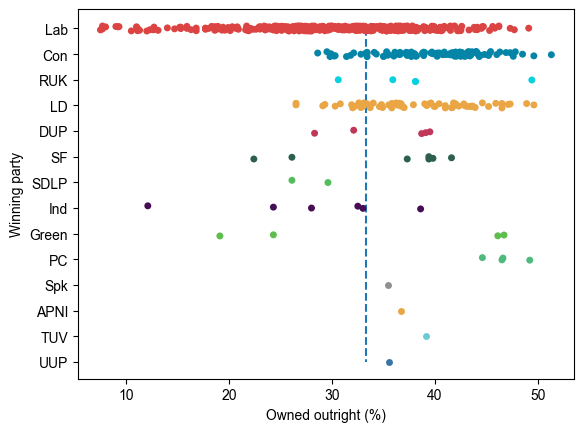

In [10]:
ax = make_stripplot(d, x='Owned outright', y='First party', hue='First party', xlabel='Owned outright (%)', ylabel='Winning party')
plt.savefig(ROOT / "src/assets/images/owned_outright.png")
plt.show()

Let's calculate the percentage of seats won by the three largest parties that had a higher than average number of people for each type of tenure. First, I'll define a function to calculate that, then call it below for different tenure types.

In [11]:
def constituencies_won_higher_than_average_tenure_type(data, tenure_type):
    for party in ['Lab', 'Con', 'LD']:
        party_seats_above_average = len(data.loc[(data['First party']==party) & (data[tenure_type] > uk_tenure_means[tenure_type])])
        party_seats = len(data.loc[data['First party']==party])
        frac = party_seats_above_average / party_seats
        p = round(frac * 100)
        print(f'For {party}, {p}% of their seats have higher than UK average percentage of homes with the tenure type: {tenure_type}.\n')
    return 

In [12]:
constituencies_won_higher_than_average_tenure_type(d, 'Owned outright')

For Lab, 37% of their seats have higher than UK average percentage of homes with the tenure type: Owned outright.

For Con, 91% of their seats have higher than UK average percentage of homes with the tenure type: Owned outright.

For LD, 79% of their seats have higher than UK average percentage of homes with the tenure type: Owned outright.



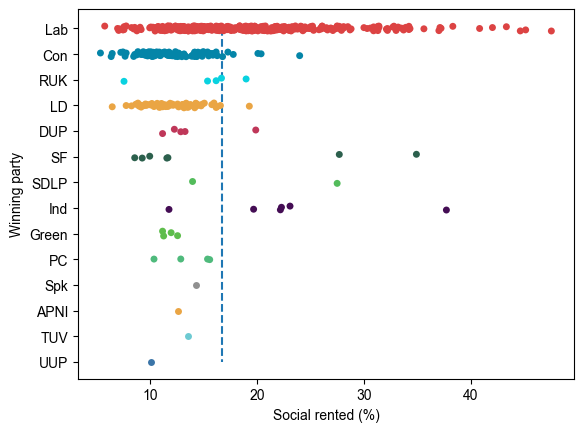

For Lab, 56% of their seats have higher than UK average percentage of homes with the tenure type: Social rented.

For Con, 5% of their seats have higher than UK average percentage of homes with the tenure type: Social rented.

For LD, 2% of their seats have higher than UK average percentage of homes with the tenure type: Social rented.



In [13]:
ax = make_stripplot(d, x='Social rented', y='First party', hue='First party', xlabel='Social rented (%)', ylabel='Winning party')
plt.savefig(ROOT / "src/assets/images/social_rented.png")
plt.show()
constituencies_won_higher_than_average_tenure_type(d, 'Social rented')

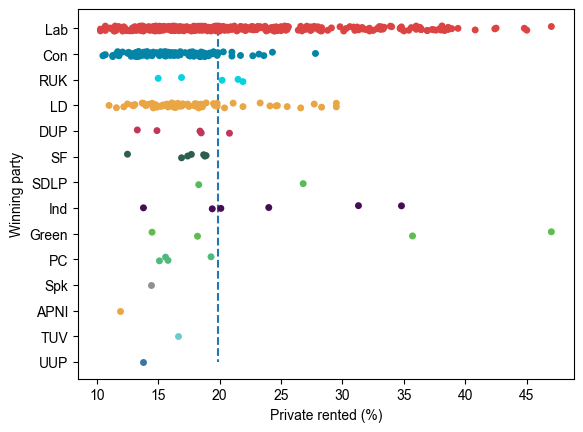

For Lab, 46% of their seats have higher than UK average percentage of homes with the tenure type: Private rented.

For Con, 9% of their seats have higher than UK average percentage of homes with the tenure type: Private rented.

For LD, 20% of their seats have higher than UK average percentage of homes with the tenure type: Private rented.



In [14]:
ax = make_stripplot(d, x='Private rented', y='First party', hue='First party', xlabel='Private rented (%)', ylabel='Winning party')
plt.savefig(ROOT / "src/assets/images/private_rented.png")
plt.show()
constituencies_won_higher_than_average_tenure_type(d, 'Private rented')

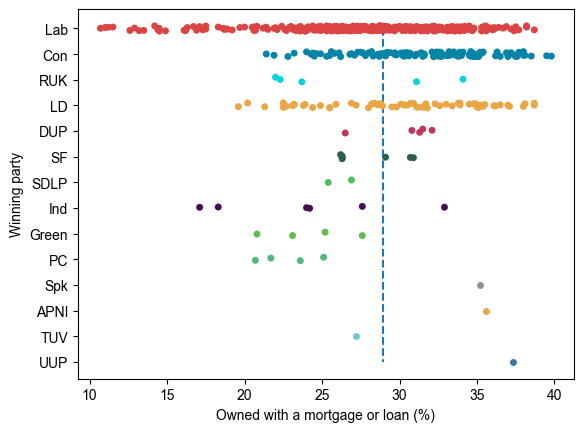

For Lab, 47% of their seats have higher than UK average percentage of homes with the tenure type: Owned with a mortgage or loan.

For Con, 73% of their seats have higher than UK average percentage of homes with the tenure type: Owned with a mortgage or loan.

For LD, 61% of their seats have higher than UK average percentage of homes with the tenure type: Owned with a mortgage or loan.



In [15]:
ax = make_stripplot(d, x='Owned with a mortgage or loan', y='First party', hue='First party', xlabel='Owned with a mortgage or loan (%)', ylabel='Winning party')
plt.savefig(ROOT / "src/assets/images/mortgage_or_loan.png")
plt.show()
constituencies_won_higher_than_average_tenure_type(d, 'Owned with a mortgage or loan')